This notebook implements the Information Theory Phase Estimation Algorithm from the paper Faster Phase Estimation by Svore, Hastings, and Freedman 2013 - https://arxiv.org/pdf/1304.0741.pdf

(In Progress)

In [33]:
from pytket.circuit import Circuit
from pytket.circuit.display import render_circuit_jupyter
import numpy as np
from pytket.circuit import CircBox, QControlBox, OpType

In [57]:
"""
m: integer multiple
omega: float in [0,2)
state_prep_circuit: Circuit that prepares an eigenvector of unitary_circuit
unitary_circuit: circuit implementing a black box unitary
"""
def build_phase_estimation_circuit(
    m: int, omega: float, state_prep_circuit: Circuit, unitary_circuit: Circuit
) -> Circuit:
    # Define a Circuit with a measurement and prep register
    qpe_circ: Circuit = Circuit()
    n_state_prep_qubits = state_prep_circuit.n_qubits
    measurement_register = qpe_circ.add_q_register("m", 1)
    state_prep_register = qpe_circ.add_q_register("p", n_state_prep_qubits)
    qpe_circ.add_circuit(state_prep_circuit, list(state_prep_register))

    # Create a controlled unitary with a single control qubit
    unitary_circuit.name = "U"
    controlled_u_gate = QControlBox(CircBox(unitary_circuit), 1)

    # Add Hadamard gate to the measurement register
    qpe_circ.H(measurement_register[0])

    # Run the controlled unitary m times
    for _ in range(m):
        qpe_circ.add_qcontrolbox(
            controlled_u_gate, list(measurement_register) + list(state_prep_register)
        )
    qpe_circ.Rz(m*omega, measurement_register[0])
    qpe_circ.H(measurement_register[0])
    qpe_circ.measure_register(measurement_register, "c")
    return qpe_circ

## Phase Estimation with a Trivial Eigenstate

Lets test our circuit construction by preparing a trivial $|1\rangle$ eigenstate of the $\text{U1}$ gate. We can then see if our phase estimation circuit returns the expected eigenvalue.

$$
\begin{equation}
U1(\phi)|1\rangle = e^{i \pi \phi}|1\rangle = e^{2 \pi i \theta} |1\rangle \implies \theta = \frac{\phi}{2}
\end{equation}
$$

So we expect that our ideal phase $\theta$ will be half the input angle $\phi$ to our $U1$ gate.

In [58]:
prep_circuit = Circuit(1).X(0)  # prepare the |1> eigenstate of U1

In [59]:
input_angle = 0.73  # angle as number of half turns

In [60]:
unitary_circuit = Circuit(1).U1(input_angle, 0)  # Base unitary for controlled U ops

In [92]:
qpe_circ_trivial = build_phase_estimation_circuit(
    m=10, omega=0, state_prep_circuit=prep_circuit, unitary_circuit=unitary_circuit
)

In [93]:
render_circuit_jupyter(qpe_circ_trivial)

Lets use the noiseless `H1-1LE` simulator to run our phase estimation circuit on Quantinuum Nexus.

In [63]:
from pytket.extensions.nexus import NexusBackend, QuantinuumConfig, Nexus
from datetime import datetime
from pytket.extensions.qiskit import AerStateBackend

In [64]:
# phase_est_project = Nexus().new_project(f"Phase Estimation Tutorial - {datetime.now()}")

# configuration = QuantinuumConfig(device_name="H1-1LE", user_group="iQuHACK_2024")


# backend = NexusBackend(
#     backend_config= configuration, 
#     project= phase_est_project
# )
backend = AerStateBackend()

In [65]:
compiled_circ = backend.get_compiled_circuit(qpe_circ_trivial)

In [66]:
n_shots = 1000
result = backend.run_circuit(compiled_circ, n_shots)

In [ ]:
def get_phase(p: float, m: int, omega: float):
    return 2*np.arccos(np.sqrt(p)) / m + omega

In [91]:
zero_count = result.get_counts()[(0,)]
frac_zero = zero_count/n_shots
print(frac_zero)
theta = get_phase(frac_zero, m=10, omega=3)
print(theta)
print(np.arccos(0))

0.048
3.2699831229439735
0.5


In [68]:
from pytket.backends.backendresult import BackendResult
import matplotlib.pyplot as plt

In [53]:
def plot_qpe_results(
    sim_result: BackendResult,
    n_strings: int = 4,
    dark_mode: bool = False,
    y_limit: int = 1000,
) -> None:
    """
    Plots results in a barchart given a BackendResult. the number of stings displayed
    can be specified with the n_strings argument.
    """
    counts_dict = sim_result.get_counts()
    sorted_shots = counts_dict.most_common()
    n_most_common_strings = sorted_shots[:n_strings]
    x_axis_values = [str(entry[0]) for entry in n_most_common_strings]  # basis states
    y_axis_values = [entry[1] for entry in n_most_common_strings]  # counts
    if dark_mode:
        plt.style.use("dark_background")
    fig = plt.figure()
    ax = fig.add_axes((0, 0, 0.75, 0.5))
    color_list = ["orange"] * (len(x_axis_values))
    ax.bar(
        x=x_axis_values,
        height=y_axis_values,
        color=color_list,
    )
    ax.set_title(label="Results")
    plt.ylim([0, y_limit])
    plt.xlabel("Basis State")
    plt.ylabel("Number of Shots")
    plt.show()

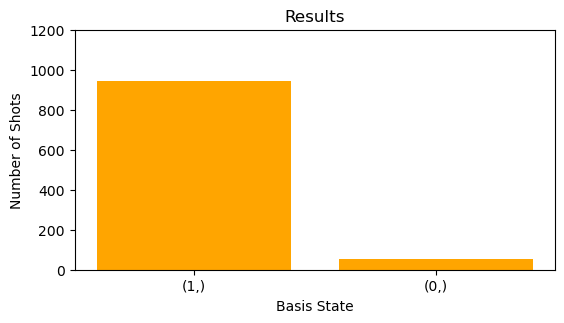

In [54]:
plot_qpe_results(result, y_limit=int(1.2 * n_shots))

As expected we see one outcome with high probability. Lets now extract our approximation of $\theta$ from our output bitstrings.

suppose the $j$ is an integer representation of our most commonly measured bitstring.

$$
\begin{equation}
\theta_{estimate} = \frac{j}{N}
\end{equation}
$$

Here $N = 2 ^m$ where $m$ is the number of measurement qubits.

In [ ]:
from pytket.backends.backendresult import BackendResult

In [ ]:
def single_phase_from_backendresult(result: BackendResult) -> float:
    # Extract most common measurement outcome
    basis_state = result.get_counts().most_common()[0][0]
    bitstring = "".join([str(bit) for bit in basis_state])
    integer_j = int(bitstring, 2)

    # Calculate theta estimate
    return integer_j / (2 ** len(bitstring))

In [ ]:
theta = single_phase_from_backendresult(result)

In [ ]:
print(theta)

In [ ]:
print(input_angle / 2)

Our output is close to half our input angle $\phi$ as expected. Lets calculate our error $E$ to three decimal places.

$$
\begin{equation}
E = |\phi - 2 \, \theta_{estimate}|
\end{equation}
$$

In [ ]:
error = round(abs(input_angle - (2 * theta)), 3)
print(error)

## Phase Estimation with Time Evolution

In the phase estimation algorithm we repeatedly perform controlled unitary operations. In the textbook variant of QPE presented here, the number of controlled unitaries will be $2^m - 1$ where $m$ is the number of measurement qubits.

In the example above we've shown a trivial instance of QPE where we know the exact phase in advance. For more realistic applications of QPE we will have some non-trivial state preparation required.

For chemistry or condensed matter physics $U$ typically be the time evolution operator $U(t) = e^{- i H t}$ where $H$ is the problem Hamiltonian.
Suppose that we had the following decomposition for $H$ in terms of Pauli strings $P_j$ and complex coefficients $\alpha_j$.

$$
\begin{equation}
H = \sum_j \alpha_j P_j\,, \quad \, P_j \in \{I, \,X, \,Y, \,Z\}^{\otimes n}
\end{equation}
$$

Here the term Pauli strings refers to tensor products of Pauli operators. These strings form an orthonormal basis for $2^n \times 2^n$ matrices.

If we have a Hamiltonian in the form above, we can then implement $U(t)$ as a sequence of Pauli gadget circuits. We can do this with the [PauliExpBox](https://tket.quantinuum.com/api-docs/circuit.html#pytket.circuit.PauliExpBox) construct in pytket. For more on `PauliExpBox` see the [user manual](https://tket.quantinuum.com/user-manual/manual_circuit.html#pauli-exponential-boxes).

Once we have a circuit to implement our time evolution operator $U(t)$, we can construct the controlled $U(t)$ operations using [QControlBox](https://tket.quantinuum.com/api-docs/circuit.html#pytket.circuit.QControlBox). If our base unitary is a sequence of `PauliExpBox`(es) then there is some structure we can exploit to simplify our circuit. See this [blog post](https://tket.quantinuum.com/blog/posts/controlled_gates/) on [ConjugationBox](https://tket.quantinuum.com/api-docs/circuit.html#pytket.circuit.ConjugationBox) for more.

As an exercise, try to use phase estimation to calculate the ground state of diatomic hydrogen $H_2$.

## Suggestions for further reading

* Quantinuum paper on Bayesian phase estimation -> https://arxiv.org/pdf/2306.16608.pdf
* Blog post on `ConjugationBox` (efficient circuits for controlled gates) -> https://tket.quantinuum.com/blog/posts/controlled_gates/